In [182]:
from joblib import dump
import numpy as np
import json
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import IsolationForest
import eif_new # Extended Isolation Forest 

In [183]:
# Loading EV Charging data and performing data filtering and transformation

ev_data = None
ev_data_frame = None

with open("../data/acndata_sessions.json") as json_file:
    ev_data = json.loads(json_file.read())
    ev_data_frame = pd.DataFrame.from_dict(ev_data["_items"], orient="columns")
    print(ev_data_frame.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16117 entries, 0 to 16116
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               16117 non-null  object 
 1   clusterID         16117 non-null  object 
 2   connectionTime    16117 non-null  object 
 3   disconnectTime    16117 non-null  object 
 4   doneChargingTime  14070 non-null  object 
 5   kWhDelivered      16117 non-null  float64
 6   sessionID         16117 non-null  object 
 7   siteID            16117 non-null  object 
 8   spaceID           16117 non-null  object 
 9   stationID         16117 non-null  object 
 10  timezone          16117 non-null  object 
 11  userID            13888 non-null  object 
 12  userInputs        13888 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.6+ MB
None


In [184]:
ev_data_frame.dropna(inplace=True)

ev_data_frame.drop(columns=["_id", "clusterID", "userID", "spaceID", "timezone", "siteID"], inplace=True)

ev_data_frame["userInputs"] = ev_data_frame["userInputs"].str[0]
ev_data_frame = pd.concat([ev_data_frame.drop(["userInputs"], axis=1), ev_data_frame["userInputs"].apply(pd.Series)], axis=1)    
ev_data_frame.drop(columns=["WhPerMile", "milesRequested", "minutesAvailable", "modifiedAt", "paymentRequired", "requestedDeparture", "sessionID", "stationID"], inplace=True)
ev_data_frame[["connectionTime", "disconnectTime", "doneChargingTime"]] = ev_data_frame[["connectionTime", "disconnectTime", "doneChargingTime"]].apply(pd.to_datetime)
# ev_data_frame["connectionDuration"] = (ev_data_frame.disconnectTime-ev_data_frame.connectionTime).astype('timedelta64[h]')
ev_data_frame["chargingDuration"] = (ev_data_frame.doneChargingTime-ev_data_frame.connectionTime).astype('timedelta64[h]')
ev_data_frame.drop(columns=["connectionTime", "disconnectTime", "doneChargingTime", "userID"], inplace=True)

print(ev_data_frame.columns)

Index(['kWhDelivered', 'kWhRequested', 'chargingDuration'], dtype='object')


In [185]:
# Tuning the isolation forest 

tuned = {'n_estimators':[1000,500], 
        'max_samples':['auto'],
        'contamination':[0.01,0.001], 
        'max_features':[3],
        'bootstrap':[True],  
        'random_state':[None,42]
}  

def scorer_f(estimator, X):   #your own scorer
    return np.mean(estimator.score_samples(X))

In [186]:
# Running model tuning and finding the parameters

isolation_forest = GridSearchCV(IsolationForest(), tuned, scoring=scorer_f)
model = isolation_forest.fit(ev_data_frame.to_numpy())

print(model.best_params_)


{'bootstrap': True, 'contamination': 0.001, 'max_features': 3, 'max_samples': 'auto', 'n_estimators': 500, 'random_state': None}


In [187]:
# Create Isolation forest with the tuned parameters

isolation_forest = IsolationForest(n_estimators=model.best_params_["n_estimators"], max_samples=model.best_params_["max_samples"], contamination=model.best_params_["contamination"], 
max_features=model.best_params_["max_features"], bootstrap=model.best_params_["bootstrap"], n_jobs=-1, random_state=model.best_params_["random_state"], verbose=1)

# Fit the model
isolation_forest.fit(ev_data_frame.to_numpy())

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


IsolationForest(bootstrap=True, contamination=0.001, max_features=3,
                n_estimators=500, n_jobs=-1, verbose=1)

In [188]:
# Test the isolation forest model with anomaly value 

test_data = pd.DataFrame([{"kWhDelivered": 126.608, "kWhRequested":100.0, "chargingDuration":4}])

pred = isolation_forest.predict(test_data.to_numpy())

print("Anomaly") if pred < 0 else print("Normal")

Normal


In [189]:
# Creating Extended Isolation Forest model and fitting

extended_isolation_forest = eif_new.iForest(ntrees=model.best_params_["n_estimators"], sample=len(ev_data_frame.to_numpy()), random_state=model.best_params_["random_state"])
extended_isolation_forest = extended_isolation_forest.fit(ev_data_frame.to_numpy())

In [190]:
# Predicting the Extended isolation forest with test value

pred = extended_isolation_forest.predict(test_data.to_numpy())

print("Anomaly") if pred else print("Normal")

Anomaly


In [191]:
# Exploring and analyzing the model explainable features using SHAP

import shap

shap.initjs()

shap_values = shap.TreeExplainer(isolation_forest).shap_values(ev_data_frame)

print(shap_values[1])

[ 0.26628035  0.47323193 -0.32677303]


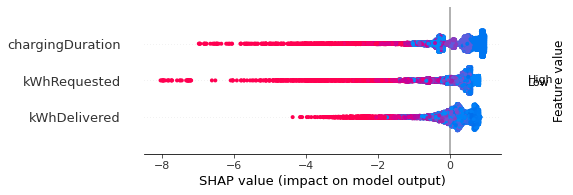

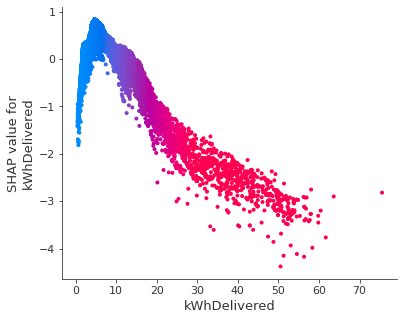

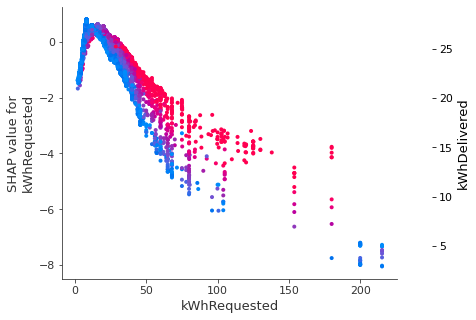

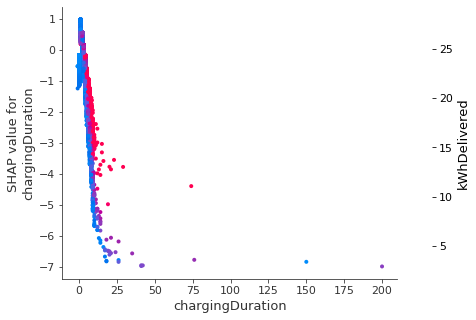

In [192]:
# visualize the prediction's explanation using the summary plot and dependence plot
shap.summary_plot(shap_values, ev_data_frame)

for name in ev_data_frame.columns:
    shap.dependence_plot(name, shap_values, ev_data_frame, interaction_index="kWhDelivered")


In [193]:
# Saving the models

dump(isolation_forest, './isolation_forest.joblib')
dump(extended_isolation_forest, './extended_isolation_forest.joblib')

['./extended_isolation_forest.joblib']